# Stock trades data in BigQuery

In this notebook we'll
- inspect stock trades data that we have in BigQuery;
- craft the query to get open, close, minimum and maximum values for a given stock symbol and defined time interval and window size;
- plot the candlestick chart

### Install jupyter extensions to draw plotly charts

In [47]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager@1.1 --no-build
!jupyter labextension install plotlywidget@1.5.2 --no-build
!jupyter labextension install jupyterlab-plotly@1.5.2 --no-build
!jupyter lab build

[LabBuildApp] JupyterLab 1.2.6
[LabBuildApp] Building in /opt/conda/share/jupyter/lab
[LabBuildApp] Building jupyterlab assets (build:prod:minimize)


<strong style="color:red">! Now restart kernel to enable extensions</strong>

### Import modules

In [48]:
from google.cloud import bigquery
import plotly.graph_objects as go
import datetime
import time
import ipywidgets as widgets
from IPython.core.display import display

### Setting constants:
- BQ_PROJECT_ID - Google Cloud project ID where dataset resides
- DEFAULT_SYMBOL - default stock symbol on which we'll be filtering trades.
- TIME_WINDOW - window for which we'll be calculating candles.

In [49]:
BQ_PROJECT_ID = 'streaming-fsi-showcase'
DEFAULT_SYMBOL = 'GE'
TIME_WINDOW = 300 # in seconds

### Inspect data in BigQuery

In [57]:
client = bigquery.Client(project = BQ_PROJECT_ID)
df = client.query('SELECT * FROM `polygon.trades` LIMIT 5').to_dataframe()
df

,ts,trade_id,trade_size,sequence_num,symbol,price
0,2018-12-31 18:48:01.282072+00:00,62879165933145,382,86096201,GM,3341
1,2018-12-31 19:54:24.023502+00:00,62879181465661,792,107980601,GPK,1061
2,2018-12-31 20:22:04.486946+00:00,71684116527188,113,55012601,GLD,12125
3,2018-12-31 19:01:48.412831+00:00,52983525099846,116,90490501,GNW,469
4,2018-12-31 19:55:45.797389+00:00,53095749406021,256,131727401,GG,972


### Inspect what symbols are in dataset

In [50]:
symbols = client.query('SELECT DISTINCT symbol FROM `polygon.trades` ORDER BY symbol').to_dataframe()

# output all symbols
print(symbols)

# output filtered symbols. e.g. characters starting with ZX
print(symbols[symbols.symbol.str.match('GO.*')])

     symbol
0         A
1        AA
2      AAAU
3       AAC
4      AADR
...     ...
6069  ZWZZT
6070  ZXIET
6071  ZXZZT
6072   ZYME
6073   ZYNE

[6074 rows x 1 columns]
     symbol
2101   GOAT
2102   GOAU
2103   GOEX
2104    GOF
2105    GOL
2106   GOLF
2107   GOOS
2108   GORO
2109   GOVT


### Select stock symbol you want to analyze

In [51]:
symbol = DEFAULT_SYMBOL

### Inspect what records do we have for a given symbol

In [52]:
info = client.query('''
  SELECT 
    MIN(UNIX_SECONDS(ts)) as min_ts, MAX(UNIX_SECONDS(ts)) as max_ts, COUNT(*) as total
  FROM `polygon.trades` WHERE symbol="{}"'''
  .format(symbol)).to_dataframe()

min_date = datetime.datetime.fromtimestamp(info['min_ts'][0])
max_date = datetime.datetime.fromtimestamp(info['max_ts'][0])

print("Info for %s:\n\tMin date: %s \n\tMax date: %s \n\tRows: %d\n" % (symbol, min_date, max_date, info['total']))

Info for GE:
	Min date: 2018-12-31 18:13:22 
	Max date: 2019-01-01 00:59:26 
	Rows: 67220



### Define date range

In [58]:
start_date_widget = widgets.DatePicker(
    description='Start Date',
    value=min_date,
    disabled=False
)
finish_date_widget = widgets.DatePicker(
    description='Finish Date',
    value=max_date,
    disabled=False
)
display(start_date_widget, finish_date_widget)

DatePicker(value=datetime.datetime(2018, 12, 31, 18, 13, 22), description='Start Date')

DatePicker(value=datetime.datetime(2019, 1, 1, 0, 59, 26), description='Finish Date')

### Query min, max,open and close prices over time windows

In [59]:
start_date = datetime.datetime.combine(start_date_widget.value, datetime.time(0,0,0)) if start_date_widget.value else datetime.datetime.combine(min_date, datetime.time(0,0,0))
finish_date = datetime.datetime.combine(finish_date_widget.value, datetime.time(23,59,59)) if start_date_widget.value else datetime.datetime.combine(max_date, datetime.time(23,59,59))

ts_start_date = int(time.mktime(start_date.timetuple()))
ts_finish_date = int(time.mktime(finish_date.timetuple()))

df = client.query('''
  SELECT
    UNIX_SECONDS(min_ts) AS min_ts, UNIX_SECONDS(max_ts) AS max_ts,
    min_price, max_price, ti1.price AS open_price, ti2.price AS close_price
  FROM (
    SELECT
      MIN(ts) AS min_ts, MAX(ts) AS max_ts, 
      MIN(price) AS min_price, MAX(price) AS max_price, 
      FLOOR((UNIX_SECONDS(ts)/{1}))
    FROM polygon.trades
    WHERE symbol="{0}" AND UNIX_SECONDS(ts)>={2} AND UNIX_SECONDS(ts)<={3}
    GROUP BY FLOOR((UNIX_SECONDS(ts)/{1}))
  ) q
  JOIN polygon.trades ti1 ON ti1.ts=min_ts AND ti1.symbol="{0}"
  JOIN polygon.trades ti2 ON ti2.ts=max_ts AND ti2.symbol="{0}"
  ORDER BY min_ts
'''.format(symbol, TIME_WINDOW, ts_start_date, ts_finish_date)).to_dataframe()

df['date'] = df.apply(lambda row: datetime.datetime.fromtimestamp(row.min_ts), axis = 1)
df.head()

,min_ts,max_ts,min_price,max_price,open_price,close_price,date
0,1546280002,1546280099,746,747,746,746,2018-12-31 18:13:22
1,1546280100,1546280399,746,748,747,748,2018-12-31 18:15:00
2,1546280401,1546280698,747,750,748,750,2018-12-31 18:20:01
3,1546280700,1546280998,749,750,750,750,2018-12-31 18:25:00
4,1546281000,1546281299,745,750,750,745,2018-12-31 18:30:00


### Plot candlestick chart

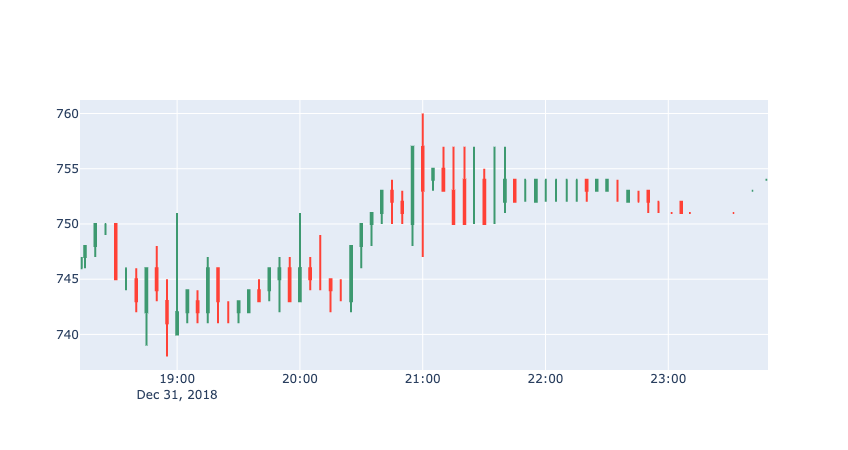

In [60]:
# STEP 6

fig = go.Figure(data=[go.Candlestick(x=df['date'],
                open=df['open_price'], high=df['max_price'],
                low=df['min_price'], close=df['close_price'])
                     ])
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()